<a href="https://colab.research.google.com/github/Funatlearn/langgraph101/blob/main/Agents/4_DrafterAgent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Boss's Orders

Create AI Agentic System that can speed up drafting documents, emails, etc. Should have Human-AI collobartion (Human should be able to prvoide continuous feed), and should stop when Human is happy with the draft. The system should be fast and be able to save the drafts.

In [1]:
# Fifth agent, to demonstrates conditional agent
# This is exercide, not completed
!pip install langgraph langchain_core langchain_openai langchain_groq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 449.6/449.6 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 9.9 MB/s eta 0:00:00
  Attempting uninstall: langchain_core
    Found existing installation: langchain-core 0.3.77
    Uninstalling langchain-core-0.3.77:
      Successfully uninstalled langchain-core-0.3.77


In [2]:

from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage, SystemMessage # Base - foundational class for all messages, Tool -> passes data back to LLM after it calls a tool, System -> provide instruction to LLM
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END # graph
from langgraph.prebuilt import ToolNode
from dotenv import load_dotenv
from langchain_groq import ChatGroq
import os
from google.colab import userdata



In [3]:
load_dotenv()

False

In [15]:
# This is global variable to store document content
document_content = ""

class AgentState(TypedDict):
  messages: Annotated[Sequence[BaseMessage], add_messages]


@tool
def update(content: str) -> str:
  """Updates the document with provided content."""
  global document_content
  document_content += content
  return f"Document has been updated successfully!. The current content is :\n{document_content}"

@tool
def save(filename: str) -> str:
  """Save the current document to text file and finish the process."""

  if not filename.endswith(".txt"):
    filename += ".txt"

  try:
    with open(filename, "w") as f:
      f.write(document_content)
    print(f"\n Document has been saved to: {filename}")
    return f"Document has been saved successfully to {filename}."
  except Exception as e:
    return f"Error saving document:{str(e)}"


  return f"Document has been updated successfully!. The current content is :\n{document_content}"

tools = [update, save]


model = ChatGroq(
    model="llama-3.1-8b-instant",
    api_key=userdata.get('GROK_KEY')
).bind_tools(tools)


def our_agent(state: AgentState) -> AgentState:
  system_prompt = SystemMessage(content=f"""
    You are Drafter, a helpful writing assistent. You are going to help the user update and modify documents.
    - If the user wants to update or modify content, use the update tool with complete updated content
    - If the user wants to save and finish, you need to use the save tool
    - Make sure to always show current document after modification.

    The current document content is : {document_content}
  """)

  if not state["messages"]:
        user_input = "I'm ready to help you update a document. What would you like to create?"
        user_message = HumanMessage(content=user_input)

  else:
        user_input = input("\nWhat would you like to do with the document? ")
        print(f"\n👤 USER: {user_input}")
        user_message = HumanMessage(content=user_input)


  all_messages = [system_prompt]+ list(state["messages"])+ [user_message]

  response = model.invoke(all_messages)

  print(f"\nASSISTANT: {response.content}")
  if hasattr(response, "tool_calls") and response.tool_calls:
        print(f"🔧 USING TOOLS: {[tc['name'] for tc in response.tool_calls]}")

  return {"messages": list(state['messages'])+ [user_message, response]}

def model_call(state:AgentState) -> AgentState:
    system_prompt = SystemMessage(content=
        "You are my AI assistant, please answer my query to the best of your ability."
    )
    response = model.invoke([system_prompt] + state["messages"])
    return {"messages": [response]}

def should_continue(state: AgentState):
    messages = state["messages"]

    if not messages:
        return "continue"

        # This looks for the most recent tool message...
    for message in reversed(messages):
      # ... and checks if this is a ToolMessage resulting from save
      if(isinstance(message, ToolMessage) and
         "saved" in message.content.lower() and
         "document" in message.content.lower()
         ):
        return "end" # goes to end edge which leads to endpoint


    return "continue"



In [16]:
graph = StateGraph(AgentState)

graph.add_node("agent", our_agent)
graph.add_node("tools", ToolNode(tools))

graph.set_entry_point("agent")

graph.add_edge("agent", "tools")


graph.add_conditional_edges(
    "tools",
    should_continue,
    {
        "continue": "agent",
        "end": END,
    },
)

app = graph.compile()

In [17]:
def print_messages(messages):
  if not messages:
    return
    for s in messages[-3:]:
        message = s["messages"][-1]
        if isinstance(message, ToolMessage  ):
            print(f"Tool RESULT: {message.content}")


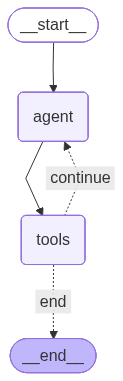

In [18]:
# display graph
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [19]:
# Run document_agent
def run_document_agent():
    print("\n ===== DRAFTER =====")

    state = {"messages": []}

    for step in app.stream(state, stream_mode="values"):
        if "messages" in step:
            print_messages(step["messages"])

    print("\n ===== DRAFTER FINISHED =====")

In [20]:
    run_document_agent()


 ===== DRAFTER =====

ASSISTANT: The current document content is: "This is a new document that we will be working on. It will contain various sections and information that we will add later."

Would you like to update or modify the content?

What would you like to do with the document? hello world

👤 USER: hello world

ASSISTANT: The current document content is: "hello world"


🔧 USING TOOLS: ['update']

What would you like to do with the document? save

👤 USER: save

ASSISTANT: 
🔧 USING TOOLS: ['save']

 Document has been saved to: document.txt

 ===== DRAFTER FINISHED =====
